# Graph-to-Simplicial Neighborhood Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "manual_dataset"  # "manual_dataset"#"PROTEINS_TU"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


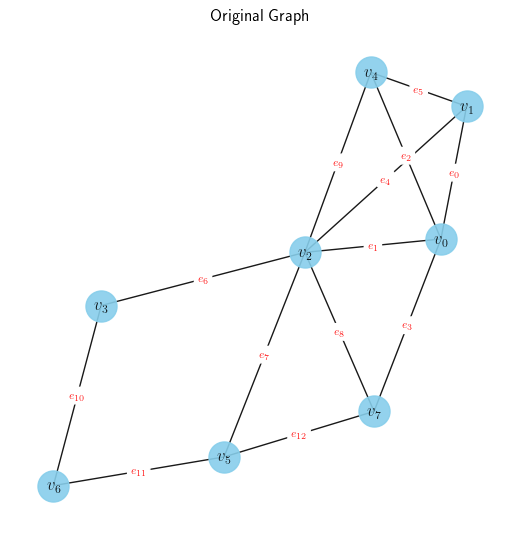

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [3]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section we will instantiate the neighborhood lifting. This lifting constructs a simplicial complex, called the **Neighborhood complex**, as it is usually defined in the field of **topological combinatorics**. Let me briefly describe this construction, for more details please see [[1]](https://doi.org/10.1007/978-3-540-76649-0).

Consider a graph $G=(V,E)$. Its neighborhood complex $N(G)$ is a simplicial complex with the vertex set $V$ and simplices given by subsets $A\subseteq V$ such, that $\forall a\in A\; \exists v: (a,v)\in E$.  That is, say, 3 vertices form a simplex iff there's another vertex which is adjacent to each of these 3 vertices. Below is an example of the constructed neighborhood complex from a graph.

![Neighborhood complex.png](<attachment:Neighborhood complex.png>)

This complex in fact can be seen as a special case of **Dowker's complex** [[2]](https://www.jstor.org/stable/1969768) (or see [this nLab page](https://ncatlab.org/nlab/show/Dowker%27s+theorem) for more details): given a graph $G=(V,E)$, consider the following symmetric relation $R$ on the set $V$ of vertices: $$ xRy \iff (x,y)\in E. $$ The Dowker's complex consists of simplices $\{x_0, ..., x_n\}$ such that $\exists y: \forall i: x_iRy$.

Then, just following the Dowker's construction, one can obtain a neighborhood complex: indeed, an existence of a simplex $\sigma$ in a neighborhood complex on the set of vertices $\{v_0, ..., v_n\}$ constitutes the existence of a vertex $w$ such that $\forall i: (v_i, w)\in E$. But then $\forall i: v_iRw$ hence there's a simplex on the vertices $\{v_0, ..., v_n\}$ in the Dowker's complex. Converse holds as well.

***
[[1]](https://doi.org/10.1007/978-3-540-76649-0) Matoušek, J. (2008). Using the Borsuk–Ulam Theorem. Springer Berlin Heidelberg.

[[2]](https://www.jstor.org/stable/1969768) C. H. Dowker, Homology Groups of Relations, Annals of Math. 56 (1952), 84–95.
***
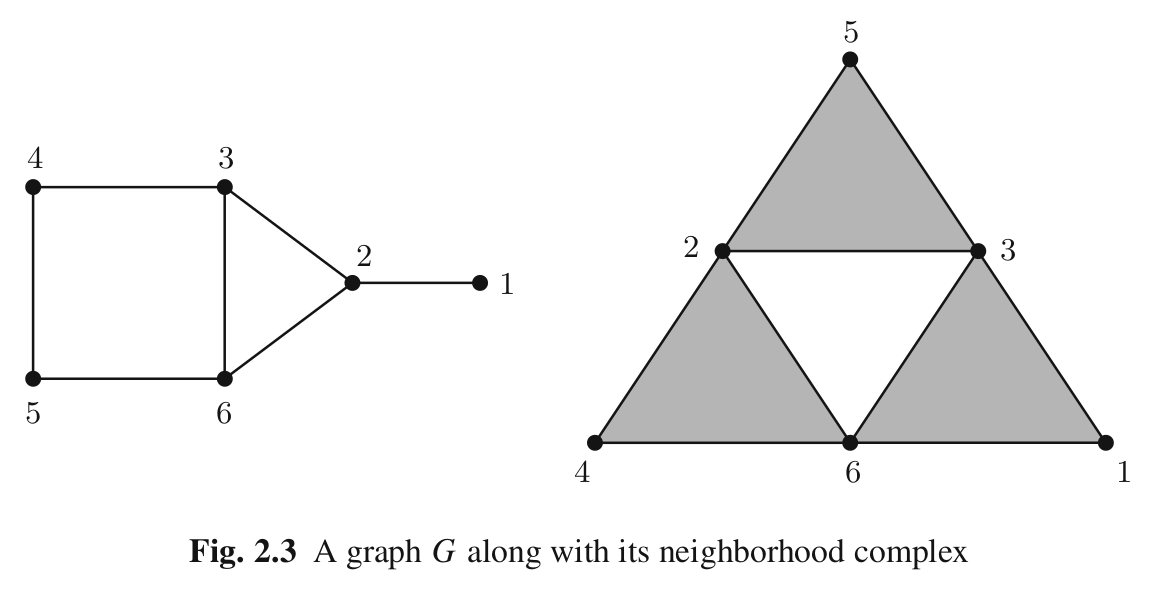

In [4]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2simplicial/neighborhood_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2simplicial/neighborhood_lifting:

{'transform_type': 'lifting',
 'transform_name': 'NeighborhoodComplexLifting',
 'preserve_edge_attr': False,
 'signed': True,
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcessor`:

Transform parameters are the same, using existing data_dir: /Users/snopoff/git_repos/challenge-icml-2024/datasets/graph/toy_dataset/manual/lifting/2172744449

Dataset only contains 1 sample:


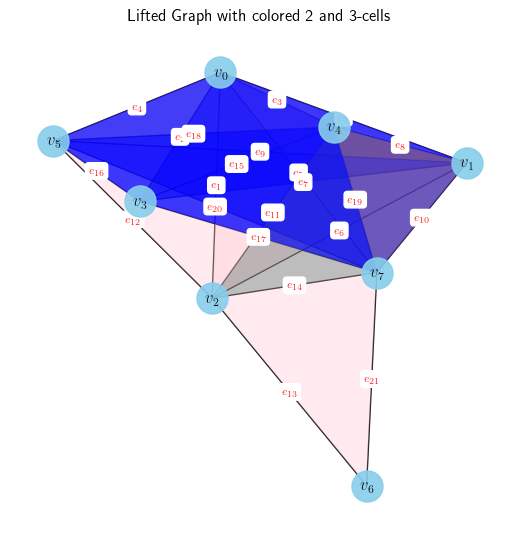

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 22 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 27 2-cells.
 - The 2-cells have features dimension 1
 - The complex has 16 3-cells.
 - The 3-cells have features dimension 1
 - The complex has 6 4-cells.
 - The 4-cells have features dimension 1
 - The complex has 1 5-cells.
 - The 5-cells have features dimension 1



In [5]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `up_laplacian_1` and the `down_laplacian_1` so the lifting should make sure to add them to the data.

In [6]:
from modules.models.simplicial.san import SANModel

model_type = "simplicial"
model_id = "san"
model_config = load_model_config(model_type, model_id)

model = SANModel(model_config, dataset_config)


Model configuration for simplicial SAN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'n_filters': 2,
 'order_harmonic': 5,
 'epsilon_harmonic': 0.1}


In [7]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 